# TLT DetectNet_v2 example usecase

This notebook shows an example usecase of Object Detection using DetectNet_v2 in the Transfer Learning Toolkit.

0. [Set up env variables](#head-0)
1. [Prepare dataset and pre-trained model](#head-1)
    1. [Verify downloaded dataset](#head-1-1)
    1. [Prepare tfrecords from kitti format dataset](#head-1-2)
    2. [Download pre-trained model](#head-1-3)
2. [Provide training specification](#head-2)
3. [Run TLT training](#head-3)
4. [Evaluate trained models](#head-4)
5. [Prune trained models](#head-5)
6. [Retrain pruned models](#head-6)
7. [Evaluate retrained model](#head-7)
8. [Visualize inferences](#head-8)
9. [Deploy](#head-9)
    1. [Int8 Optimization](#head-9-1)
    2. [Generate TensorRT engine](#head-9-2)
10. [Verify Deployed Model](#head-10)
    1. [Inference using TensorRT engine](#head-10-1)
11. [QAT workflow](#head-11)
    1. [Convert pruned model to QAT and retrain](#head-11-1)
    2. [Evaluate QAT converted model](#head-11-2)
    3. [Export QAT trained model to int8](#head-11-3)
    4. [Evaluate a QAT trained model using the exported TensorRT engine](#head-11-4)
    5. [Inference using QAT engine](#head-11-5)
    

## 0. Set up env variables <a class="anchor" id="head-0"></a>
When using the purpose-built pretrained models from NGC, please make sure to set the `$KEY` environment variable to the key as mentioned in the model overview. Failing to do so, can lead to errors when trying to load them as pretrained models.

*Note: Please make sure to remove any stray artifacts/files from the `$USER_EXPERIMENT_DIR` or `$DATA_DOWNLOAD_DIR` paths as mentioned below, that may have been generated from previous experiments. Having checkpoint files etc may interfere with creating a training graph for a new experiment.*

*Note: This notebook currently is by default set up to run training using 1 GPU. To use more GPU's please update the env variable `$NUM_GPUS` accordingly*

In [2]:
# Setting up env variables for cleaner command line commands.
%env KEY= "YOUR KEY"
%env USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2_aug
%env DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data
%env SPECS_DIR=/workspace/examples/detectnet_v2_aug/specs
%env NUM_GPUS=1

env: KEY="YOUR KEY"
env: USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2_aug
env: DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data
env: SPECS_DIR=/workspace/examples/detectnet_v2_aug/specs
env: NUM_GPUS=1


### B. Prepare tf records from kitti format dataset <a class="anchor" id="head-1-2"></a>

* Update the tfrecords spec file to take in your kitti format dataset
* Create the tfrecords using the tlt-dataset-convert 

*Note: TfRecords only need to be generated once.*

In [4]:
print("TFrecords conversion spec file for kitti training")
!cat $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt

TFrecords conversion spec file for kitti training
kitti_config {
  root_directory_path: "/workspace/tlt-experiments/data/train_aug"
  image_dir_name: "images"
  label_dir_name: "labels"
  image_extension: ".jpg"
  partition_mode: "random"
  num_partitions: 2
  val_split: 10
  num_shards: 10
}
image_directory_path: "/workspace/tlt-experiments/data/train_aug"


In [5]:
# Creating a new directory for the output tfrecords dump.
print("Converting Tfrecords for kitti trainval dataset")
!tlt-dataset-convert -d $SPECS_DIR/detectnet_v2_tfrecords_kitti_trainval.txt \
                     -o $DATA_DOWNLOAD_DIR/tfrecords_aug/kitti_trainval/kitti_trainval

Converting Tfrecords for kitti trainval dataset
2021-10-22 06:32:09.272999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2021-10-22 06:32:14,675 - iva.detectnet_v2.dataio.build_converter - INFO - Instantiating a kitti converter
2021-10-22 06:32:14,675 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Creating output directory /workspace/tlt-experiments/data/tfrecords_aug/kitti_trainval
2021-10-22 06:32:14,683 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Num images in
Train: 3136	Val: 348
2021-10-22 06:32:14,683 - iva.detectnet_v2.dataio.kitti_converter_lib - INFO - Validation data in partition 0. Hence, while choosing the validationset during training choose validation_fold 0.
2021-10-22 06:32:14,685 - iva.detectnet_v2.dataio.dataset_converter_lib - INFO - Writing partition 0, shard 0

2021-10-22 06:32:14,686 - tensorflow - WARNING - From /home/vpraveen/.cache/dazel/_daze

In [6]:
!ls -rlt $DATA_DOWNLOAD_DIR/tfrecords_aug/kitti_trainval/

total 2128
-rw-r--r-- 1 root root  20870 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00000-of-00010
-rw-r--r-- 1 root root  20863 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00001-of-00010
-rw-r--r-- 1 root root  20875 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00002-of-00010
-rw-r--r-- 1 root root  20870 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00003-of-00010
-rw-r--r-- 1 root root  20854 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00004-of-00010
-rw-r--r-- 1 root root  20845 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00005-of-00010
-rw-r--r-- 1 root root  20865 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00006-of-00010
-rw-r--r-- 1 root root  20881 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00007-of-00010
-rw-r--r-- 1 root root  20876 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00008-of-00010
-rw-r--r-- 1 root root  25757 Oct 22 06:32 kitti_trainval-fold-000-of-002-shard-00009-of-00010
-rw-r--r-- 1 root root 192148 Oct 22 06

### C. Download pre-trained model <a class="anchor" id="head-1-3"></a>
Download the correct pretrained model from the NGC model registry for your experiment. Please note that for DetectNet_v2, the input is expected to be 0-1 normalized with input channels in RGB order. Therefore, for optimum results please download model templates from `nvidia/tlt_pretrained_detectnet_v2`. The templates are now organizede as version strings. For example, to download a resnet18 model suitable for detectnet please resolve to the ngc object shown as `nvidia/tlt_pretrained_detectnet_v2:resnet18`. 

All other models expect input preprocessing with mean subtraction and input channels in BGR order. Thus, using them as pretrained weights may result in suboptimal performance. 

In [7]:
# List models available in the model registry.
!ngc registry model list nvidia/tlt_pretrained_detectnet_v2:*

+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| Versi | Accur | Epoch | Batch | GPU   | Memor | File  | Statu | Creat |
| on    | acy   | s     | Size  | Model | y Foo | Size  | s     | ed    |
|       |       |       |       |       | tprin |       |       | Date  |
|       |       |       |       |       | t     |       |       |       |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| vgg19 | 82.6  | 80    | 1     | V100  | 153.8 | 153.7 | UPLOA | Apr   |
|       |       |       |       |       |       | 7 MB  | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| vgg16 | 82.2  | 80    | 1     | V100  | 113.2 | 113.2 | UPLOA | Apr   |
|       |       |       |       |       |       | MB    | D_COM | 29,   |
|       |       |       |       |       |       |       | PLETE | 2020  |
| squee | 65.67 | 80    | 1     | V100  | 6.5   | 6.46  | UPLOA | Apr   |
| zenet |       |       |       |     

In [8]:
# Create the target destination to download the model.
!mkdir -p $USER_EXPERIMENT_DIR/pretrained_resnet18/

In [9]:
# Download the pretrained model from NGC
!ngc registry model download-version nvidia/tlt_pretrained_detectnet_v2:resnet18 \
    --dest $USER_EXPERIMENT_DIR/pretrained_resnet18

Downloaded 82.28 MB in 4s, Download speed: 20.52 MB/s               
----------------------------------------------------
Transfer id: tlt_pretrained_detectnet_v2_vresnet18 Download status: Completed.
Downloaded local path: /workspace/tlt-experiments/detectnet_v2_aug/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18
Total files downloaded: 1 
Total downloaded size: 82.28 MB
Started at: 2021-10-22 06:33:38.796270
Completed at: 2021-10-22 06:33:42.802258
Duration taken: 4s
----------------------------------------------------


In [10]:
!ls -rlt $USER_EXPERIMENT_DIR/pretrained_resnet18/tlt_pretrained_detectnet_v2_vresnet18

total 91160
-rw------- 1 root root 93345248 Oct 22 06:33 resnet18.hdf5


## 2. Provide training specification <a class="anchor" id="head-2"></a>
* Tfrecords for the train datasets
    * In order to use the newly generated tfrecords, update the dataset_config parameter in the spec file at `$SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt` 
    * Update the fold number to use for evaluation. In case of random data split, please use fold `0` only
    * For sequence-wise split, you may use any fold generated from the dataset convert tool
* Pre-trained models
* Augmentation parameters for on the fly data augmentation
* Other training (hyper-)parameters such as batch size, number of epochs, learning rate etc.

In [2]:
!cat $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt

random_seed: 42
dataset_config {
  data_sources {
    tfrecords_path: "/workspace/tlt-experiments/data/tfrecords_aug/kitti_trainval/*"
    image_directory_path: "/workspace/tlt-experiments/data/train_aug"
  }
  image_extension: "jpg"
  target_class_mapping {
    key: "defect"
    value: "defect"
  }
  validation_fold: 0
}
augmentation_config {
  preprocessing {
    output_image_width: 208
    output_image_height: 208
    min_bbox_width: 1.0
    min_bbox_height: 1.0
    output_image_channel: 3
  }
  spatial_augmentation {
    hflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation {
    hue_rotation_max: 25.0
    saturation_shift_max: 0.20000000298
    contrast_scale_max: 0.10000000149
    contrast_center: 0.5
  }
}
postprocessing_config {
  target_class_config {
    key: "defect"
    value {
      clustering_config {
        coverage_threshold: 0.00499999988824
        dbscan_eps: 0.20000000298
        dbscan

## 3. Run TLT training <a class="anchor" id="head-3"></a>
* Provide the sample spec file and the output directory location for models

*Note: The training may take hours to complete. Also, the remaining notebook, assumes that the training was done in single-GPU mode. When run in multi-GPU mode, please expect to update the pruning and inference steps with new pruning thresholds and updated parameters in the clusterfile.json accordingly for optimum performance.*

*Detectnet_v2 now supports restart from checkpoint. Incase, the training job is killed prematurely, you may resume training from the closest checkpoint by simply re-running the **same** command line. Please do make sure to use the <u>**same number of GPUs**</u> when restarting the training.*

*When running the training with NUM_GPUs>1, you may need to modify the `batc_size_per_gpu` and `learning_rate` to get similar mAP as a 1GPU training run. In most cases, scaling down the batch-size by a factor of NUM_GPU's or scaling up the learning rate by a factor of NUM_GPU's would be a good place to start.* 

In [3]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_unpruned/

In [4]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_unpruned \
                        -k $KEY \
                        -n resnet18_detector \
                        --gpus $NUM_GPUS

Using TensorFlow backend.
2021-10-22 11:08:59.125981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
--------------------------------------------------------------------------
[[39620,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 87d0501a6dea

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
2021-10-22 11:09:06.355982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 11:09:06.403177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be a

Total params: 11,197,893
Trainable params: 11,188,165
Non-trainable params: 9,728
__________________________________________________________________________________________________
2021-10-22 11:09:20,405 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Serial augmentation enabled = False
2021-10-22 11:09:20,405 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Pseudo sharding enabled = False
2021-10-22 11:09:20,405 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: Max Image Dimensions (all sources): (0, 0)
2021-10-22 11:09:20,405 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: number of cpus: 4, io threads: 8, compute threads: 4, buffered batches: 4
2021-10-22 11:09:20,405 [INFO] modulus.blocks.data_loaders.multi_source_loader.data_loader: total dataset size 3136, number of sources: 1, batch size per gpu: 32, steps: 98
2021-10-22 11:09:20,508 [INFO] iva.detectnet_v2.dataloader.default_dataloader: Bounding box c

2021-10-22 11:09:56.755211: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-22 11:09:56.762509: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-10-22 11:10:00,465 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 0/240: loss: 0.08908 Time taken: 0:00:00 ETA: 0:00:00
2021-10-22 11:10:00,465 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 4.395
2021-10-22 11:10:09,320 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 49.580
2021-10-22 11:10:12,465 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 254.367
2021-10-22 11:10:15,613 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 254.209
2021-10-22 11:10:18,891 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 1/240: loss: 0.00836 Time taken: 0:00

2021-10-22 11:13:05,123 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 238.157
2021-10-22 11:13:08,490 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 237.649
2021-10-22 11:13:11,871 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 236.654
2021-10-22 11:13:14,983 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 14/240: loss: 0.00267 Time taken: 0:00:13.214895 ETA: 0:49:46.566380
2021-10-22 11:13:15,254 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 236.504
2021-10-22 11:13:18,629 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 237.004
2021-10-22 11:13:22,016 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 236.209
2021-10-22 11:13:25,433 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 234.183
2021-10-22 11:13:28,270 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 15/240: loss: 0.00245 

2021-10-22 11:16:15,598 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.079
2021-10-22 11:16:19,057 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.301
2021-10-22 11:16:22,523 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.880
2021-10-22 11:16:25,986 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.037
2021-10-22 11:16:28,760 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 28/240: loss: 0.00168 Time taken: 0:00:13.572502 ETA: 0:47:57.370402
2021-10-22 11:16:29,457 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.523
2021-10-22 11:16:32,922 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.856
2021-10-22 11:16:36,397 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.246
2021-10-22 11:16:39,864 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.780
2021-10-22 11:16:42,378 [INFO] /usr/local/lib/pyt

2021-10-22 11:19:22,974 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 94.671
2021-10-22 11:19:26,428 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.640
2021-10-22 11:19:29,891 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.065
2021-10-22 11:19:33,346 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.585
2021-10-22 11:19:35,990 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 41/240: loss: 0.00130 Time taken: 0:00:13.582600 ETA: 0:45:02.937376
2021-10-22 11:19:36,825 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.938
2021-10-22 11:19:40,293 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.727
2021-10-22 11:19:43,767 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.259
2021-10-22 11:19:47,235 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.729
2021-10-22 11:19:49,608 [INFO] /usr/local/lib/pyth

2021-10-22 11:22:39,037 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.233
2021-10-22 11:22:42,511 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.352
2021-10-22 11:22:45,998 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.386
2021-10-22 11:22:49,485 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.444
2021-10-22 11:22:51,717 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 55/240: loss: 0.00118 Time taken: 0:00:13.645988 ETA: 0:42:04.507778
2021-10-22 11:22:52,971 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.534
2021-10-22 11:22:56,454 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.736
2021-10-22 11:22:59,938 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.589
2021-10-22 11:23:03,425 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.437
2021-10-22 11:23:05,377 [INFO] /usr/local/lib/pyt

2021-10-22 11:25:55,327 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.817
2021-10-22 11:25:58,825 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.727
2021-10-22 11:26:02,316 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.151
2021-10-22 11:26:05,803 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.431
2021-10-22 11:26:07,623 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 69/240: loss: 0.00099 Time taken: 0:00:13.689077 ETA: 0:39:00.832191
2021-10-22 11:26:09,307 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.334
2021-10-22 11:26:12,800 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.052
2021-10-22 11:26:16,303 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.431
2021-10-22 11:26:19,790 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.402
2021-10-22 11:26:24,396 [INFO] iva.detectnet_v2.e

2021-10-22 11:29:02,139 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.931
2021-10-22 11:29:05,615 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.186
2021-10-22 11:29:09,089 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.307
2021-10-22 11:29:12,567 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.067
2021-10-22 11:29:14,250 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 82/240: loss: 0.00093 Time taken: 0:00:13.648005 ETA: 0:35:56.384754
2021-10-22 11:29:16,064 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.786
2021-10-22 11:29:19,560 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 228.821
2021-10-22 11:29:23,051 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.205
2021-10-22 11:29:26,540 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 229.271
2021-10-22 11:29:27,939 [INFO] /usr/local/lib/pyt

2021-10-22 11:32:17,225 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.502
2021-10-22 11:32:20,686 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.189
2021-10-22 11:32:24,151 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.924
2021-10-22 11:32:27,611 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.178
2021-10-22 11:32:28,863 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 96/240: loss: 0.00081 Time taken: 0:00:13.583456 ETA: 0:32:36.017601
2021-10-22 11:32:31,077 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 230.840
2021-10-22 11:32:34,534 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.468
2021-10-22 11:32:37,992 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 231.369
2021-10-22 11:32:41,439 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 232.128
2021-10-22 11:32:42,414 [INFO] /usr/local/lib/pyt

2021-10-22 11:35:31,420 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 232.334
2021-10-22 11:35:34,854 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 232.948
2021-10-22 11:35:38,300 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 232.151
2021-10-22 11:35:41,748 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 232.076
2021-10-22 11:35:45,676 [INFO] iva.detectnet_v2.evaluation.evaluation: step 0 / 10, 0.00s/step
Matching predictions to ground truth, class 1/1.: 100%|█| 854/854 [00:00<00:00, 18177.34it/s]
Epoch 110/240

Validation cost: 0.000661
Mean average_precision (in %): 52.3694

class name      average precision (in %)
------------  --------------------------
defect                           52.3694

Median Inference Time: 0.001907
2021-10-22 11:35:46,888 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 110/240: loss: 0.00067 Time taken: 0:00:17.800454 ETA: 0:38:34.058976
20

2021-10-22 11:38:37,469 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 219.339
2021-10-22 11:38:41,098 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 220.489
2021-10-22 11:38:44,723 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 220.705
2021-10-22 11:38:48,354 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 220.356
2021-10-22 11:38:49,079 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 123/240: loss: 0.00065 Time taken: 0:00:14.223322 ETA: 0:27:44.128664
2021-10-22 11:38:51,985 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 220.344
2021-10-22 11:38:55,605 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 220.989
2021-10-22 11:38:59,262 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 218.790
2021-10-22 11:39:02,881 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 221.107
2021-10-22 11:39:03,318 [INFO] /usr/local/lib/py

2021-10-22 11:44:04,547 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 111.133
2021-10-22 11:44:11,808 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.191
2021-10-22 11:44:19,104 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.645
2021-10-22 11:44:26,405 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.580
2021-10-22 11:44:26,983 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 137/240: loss: 0.00060 Time taken: 0:00:28.446372 ETA: 0:48:49.976344
2021-10-22 11:44:33,656 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.336
2021-10-22 11:44:40,915 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.220
2021-10-22 11:44:48,212 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.641
2021-10-22 11:44:52,684 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 138/240: loss: 0.0006

2021-10-22 11:56:31,000 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.229
2021-10-22 11:56:38,183 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 111.380
2021-10-22 11:56:45,402 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.820
2021-10-22 11:56:52,061 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 164/240: loss: 0.00056 Time taken: 0:00:28.183425 ETA: 0:35:41.940314
2021-10-22 11:56:52,642 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.509
2021-10-22 11:56:59,895 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.304
2021-10-22 11:57:07,062 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 111.618
2021-10-22 11:57:14,337 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.981
2021-10-22 11:57:20,466 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 165/240: loss: 0.0006

2021-10-22 12:02:48,557 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 216.051
2021-10-22 12:02:55,657 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 112.694
2021-10-22 12:03:02,932 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.958
2021-10-22 12:03:10,235 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.550
2021-10-22 12:03:16,078 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 178/240: loss: 0.00046 Time taken: 0:00:27.930123 ETA: 0:28:51.667617
2021-10-22 12:03:17,512 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.949
2021-10-22 12:03:24,783 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.029
2021-10-22 12:03:32,080 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.643
2021-10-22 12:03:39,379 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.607
2021-10-22 12:03:44,542 [INFO] /usr/local/lib/py

2021-10-22 12:08:53,268 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 59.836
2021-10-22 12:09:00,509 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.486
2021-10-22 12:09:05,466 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 161.392
2021-10-22 12:09:10,841 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 148.835
2021-10-22 12:09:16,427 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 191/240: loss: 0.00040 Time taken: 0:00:24.347056 ETA: 0:19:53.005728
2021-10-22 12:09:18,180 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.018
2021-10-22 12:09:25,397 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.854
2021-10-22 12:09:32,721 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.233
2021-10-22 12:09:40,023 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.566
2021-10-22 12:09:44,977 [INFO] /usr/local/lib/pyt

2021-10-22 12:15:17,128 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.320
2021-10-22 12:15:24,393 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.125
2021-10-22 12:15:29,461 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 157.872
2021-10-22 12:15:34,673 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 153.493
2021-10-22 12:15:39,350 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 205/240: loss: 0.00036 Time taken: 0:00:24.213513 ETA: 0:14:07.472968
2021-10-22 12:15:41,946 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.010
2021-10-22 12:15:49,240 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.689
2021-10-22 12:15:56,501 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 110.186
2021-10-22 12:16:03,784 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 109.848
2021-10-22 12:16:07,883 [INFO] /usr/local/lib/py

2021-10-22 12:20:51,274 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 247.560
2021-10-22 12:20:54,501 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 247.873
2021-10-22 12:20:57,744 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 246.722
2021-10-22 12:21:00,974 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 247.707
2021-10-22 12:21:02,671 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 219/240: loss: 0.00033 Time taken: 0:00:12.685013 ETA: 0:04:26.385264
2021-10-22 12:21:04,231 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 245.653
2021-10-22 12:21:07,472 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 246.829
2021-10-22 12:21:10,729 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 245.678
2021-10-22 12:21:13,986 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 245.685
2021-10-22 12:21:18,511 [INFO] iva.detectnet_v2.

2021-10-22 12:23:44,425 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 237.575
2021-10-22 12:23:47,787 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 238.015
2021-10-22 12:23:51,117 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 240.223
2021-10-22 12:23:54,485 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 237.576
2021-10-22 12:23:56,097 [INFO] /usr/local/lib/python3.6/dist-packages/modulus/hooks/task_progress_monitor_hook.pyc: Epoch 232/240: loss: 0.00034 Time taken: 0:00:13.154438 ETA: 0:01:45.235506
2021-10-22 12:23:57,834 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 238.887
2021-10-22 12:24:01,220 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 236.320
2021-10-22 12:24:04,624 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 234.996
2021-10-22 12:24:08,035 [INFO] modulus.hooks.sample_counter_hook: Train Samples / sec: 234.569
2021-10-22 12:24:09,391 [INFO] /usr/local/lib/py

In [5]:
print('Model for each epoch:')
print('---------------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights

Model for each epoch:
---------------------
total 43M
-rw-r--r-- 1 root root 43M Oct 22 12:26 resnet18_detector.tlt


## 4. Evaluate the trained model <a class="anchor" id="head-4"></a>

In [7]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
                           -k $KEY

Using TensorFlow backend.
2021-10-22 12:33:15.863431: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:33:19,213 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/examples/detectnet_v2_aug/specs/detectnet_v2_train_resnet18_kitti.txt
2021-10-22 12:33:20.805219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:33:20.827167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:33:20.827683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:33:20.827719: I tensorflow/stream_executor/platform/default/dso_loader

2021-10-22 12:33:26.001511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:33:26.001937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:33:26.001993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:33:26.002051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-22 12:33:26.002072: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-10-22 12:33:26.002092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.1

## 5. Prune the trained model <a class="anchor" id="head-5"></a>
* Specify pre-trained model
* Equalization criterion (`Applicable for resnets and mobilenets`)
* Threshold for pruning.
* A key to save and load the model
* Output directory to store the model

*Usually, you just need to adjust `-pth` (threshold) for accuracy and model size trade off. Higher `pth` gives you smaller model (and thus higher inference speed) but worse accuracy. The threshold to use is depend on the dataset. A pth value `5.2e-6` is just a start point. If the retrain accuracy is good, you can increase this value to get smaller models. Otherwise, lower this value to get better accuracy.*

*For some internal studies, we have noticed that a pth value of 0.01 is a good starting point for detectnet_v2 models.*

In [9]:
# Create an output directory if it doesn't exist.
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_pruned

In [10]:
!tlt-prune -m $USER_EXPERIMENT_DIR/experiment_dir_unpruned/weights/resnet18_detector.tlt \
           -o $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
           -eq union \
           -pth 0.01 \
           -k $KEY

2021-10-22 12:35:36.348372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
Using TensorFlow backend.
2021-10-22 12:35:41.243071: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:35:41.266821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:35:41.267359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:35:41.267407: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:35:41.268855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic 

In [11]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_pruned/

total 36024
-rw-r--r-- 1 root root 36885384 Oct 22 12:36 resnet18_nopool_bn_detectnet_v2_pruned.tlt


In [12]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
                           -k $KEY

Using TensorFlow backend.
2021-10-22 12:37:35.207029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:37:37,905 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/examples/detectnet_v2_aug/specs/detectnet_v2_train_resnet18_kitti.txt
2021-10-22 12:37:39.209527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:37:39.256491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:37:39.257080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:37:39.257112: I tensorflow/stream_executor/platform/default/dso_loader

2021-10-22 12:37:43.052937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:37:43.053320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:37:43.053362: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:37:43.053409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-22 12:37:43.053428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-10-22 12:37:43.053446: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.1

## 6. Retrain the pruned model <a class="anchor" id="head-6"></a>
* Model needs to be re-trained to bring back accuracy after pruning
* Specify re-training specification with pretrained weights as pruned model.

*Note: For retraining, please set the `load_graph` option to `true` in the model_config to load the pruned model graph. Also, if after retraining, the model shows some decrease in mAP, it could be that the originally trained model, was pruned a little too much. Please try reducing the pruning threshold, thereby reducing the pruning ratio, and use the new model to retrain.*

*Note: DetectNet_v2 now supports Quantization Aware Training, to help with optmizing the model. By default the training in the cell below doesn't run the model with QAT enabled. For information on training a model with QAT please refer to the cells under [section 11](#head-11)*

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to include the 
# newly pruned model as a pretrained weights and, the
# load_graph option is set to true 
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt

In [ ]:
# Retraining using the pruned model as pretrained weights 
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain \
                        -k $KEY \
                        -n resnet18_detector_pruned \
                        --gpus $NUM_GPUS

In [ ]:
# Listing the newly retrained model.
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights

## 7. Evaluate the retrained model <a class="anchor" id="head-7"></a>

This section evaluates the pruned and retrained model, using `tlt-evaluate`.

In [14]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_train_resnet18_kitti.txt\
                           -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
                           -k $KEY

Using TensorFlow backend.
2021-10-22 12:52:08.660908: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:52:11,353 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /workspace/examples/detectnet_v2_aug/specs/detectnet_v2_train_resnet18_kitti.txt
2021-10-22 12:52:12.669046: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:52:12.723952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:52:12.724546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:52:12.724582: I tensorflow/stream_executor/platform/default/dso_loader

2021-10-22 12:52:16.560612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:52:16.561036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:52:16.561095: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:52:16.561149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-22 12:52:16.561168: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-10-22 12:52:16.561186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.1

In [ ]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
                           -k $KEY

## 8. Visualize inferences <a class="anchor" id="head-8"></a>
In this section, we run the `tlt-infer` tool to generate inferences on the trained models. To render bboxes from more classes, please edit the spec file `detectnet_v2_inference_kitti_tlt.txt` to include all the classes you would like to visualize and edit the rest of the file accordingly.

In [16]:
!ls -la $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt

-rw-r--r-- 1 root root 36885384 Oct 22 12:36 /workspace/tlt-experiments/detectnet_v2_aug/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt


In [17]:
!cat $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt

inferencer_config{
  # defining target class names for the experiment.
  # Note: This must be mentioned in order of the networks classes.
  target_classes: "defect"
  # Inference dimensions.
  image_width: 208
  image_height: 208
  # Must match what the model was trained for.
  image_channels: 3
  batch_size: 32
  gpu_index: 0
  # model handler config
  tlt_config{
    model: "/workspace/tlt-experiments/detectnet_v2_aug/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt"
  }
}
bbox_handler_config{
  kitti_dump: true
  disable_overlay: false
  overlay_linewidth: 2
  classwise_bbox_handler_config{
    key:"defect"
    value: {
      confidence_model: "aggregate_cov"
      output_map: "defect"
      confidence_threshold: 0.5
      bbox_color{
        R: 0
        G: 255
        B: 0
      }
      clustering_config{
        coverage_threshold: 0.00
        dbscan_eps: 0.3
        dbscan_min_samples: 0.05
        minimum_bounding_box_height: 4
      }
    }
  }
  classwise_bbo

In [18]:
# Running inference for detection on n images
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_tlt.txt \
                        -o $USER_EXPERIMENT_DIR/tlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/val/images \
                        -k $KEY

Using TensorFlow backend.
2021-10-22 12:57:37.757503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:57:40,586 [INFO] iva.detectnet_v2.scripts.inference: Creating output inference directory
2021-10-22 12:57:40,586 [INFO] iva.detectnet_v2.scripts.inference: Overlain images will be saved in the output path.
2021-10-22 12:57:40,586 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer
2021-10-22 12:57:40.587320: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:57:40.587524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:57:40.588125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 mino

The `tlt-infer` tool produces two outputs. 
1. Overlain images in `$USER_EXPERIMENT_DIR/tlt_infer_testing/images_annotated`
2. Frame by frame bbox labels in kitti format located in `$USER_EXPERIMENT_DIR/tlt_infer_testing/labels`

*Note: To run inferences for a single image, simply replace the path to the -i flag in `tlt-infer` command with the path to the image.*

In [19]:
# Simple grid visualizer
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['USER_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[:num_images]):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img)

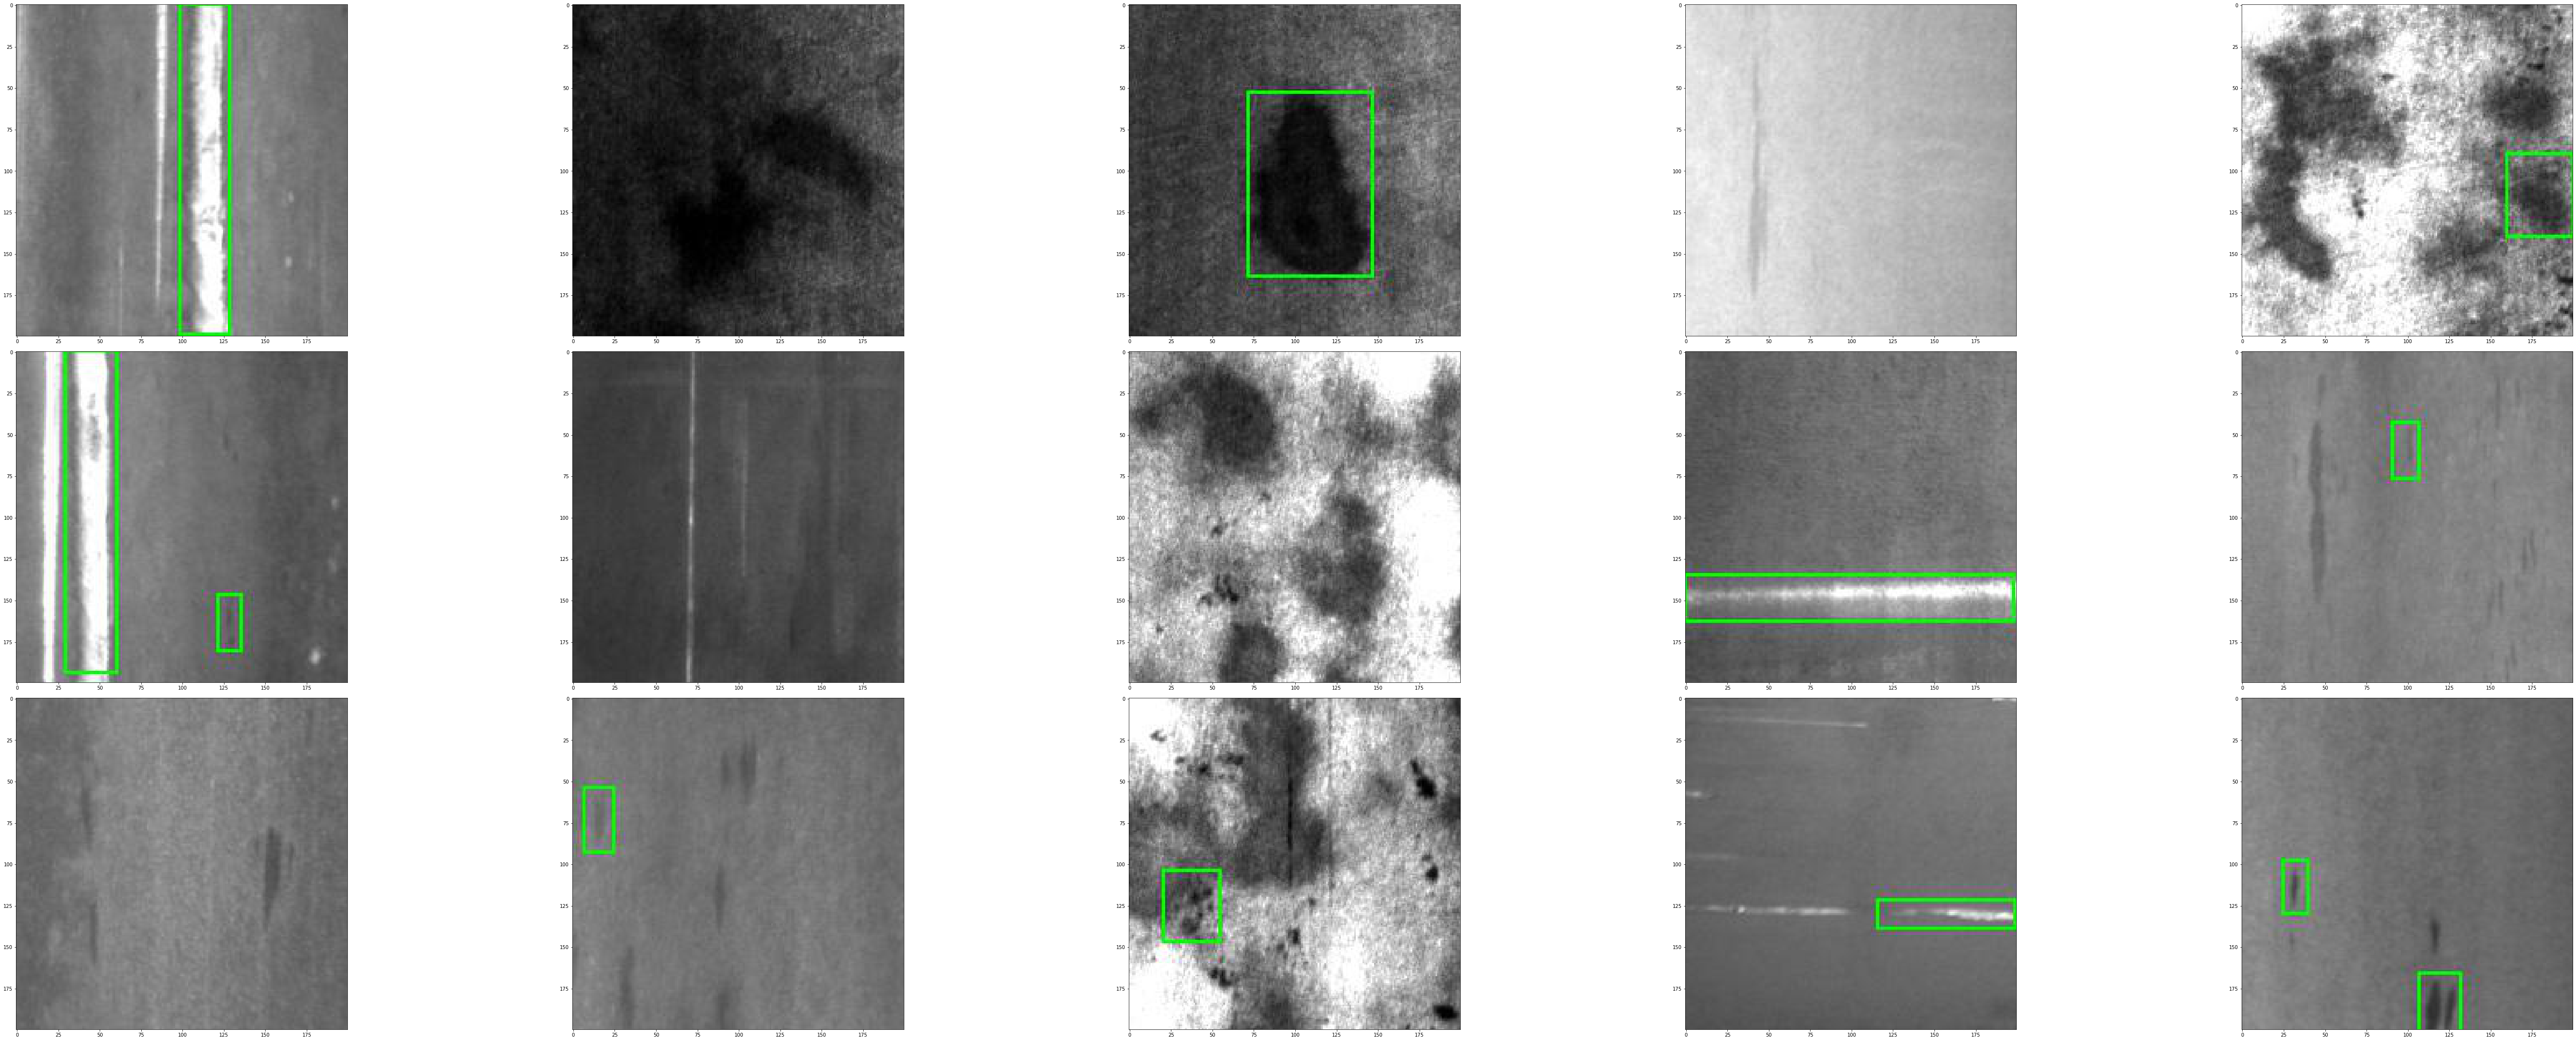

In [20]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'tlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 5 # number of columns in the visualizer grid.
IMAGES = 15 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

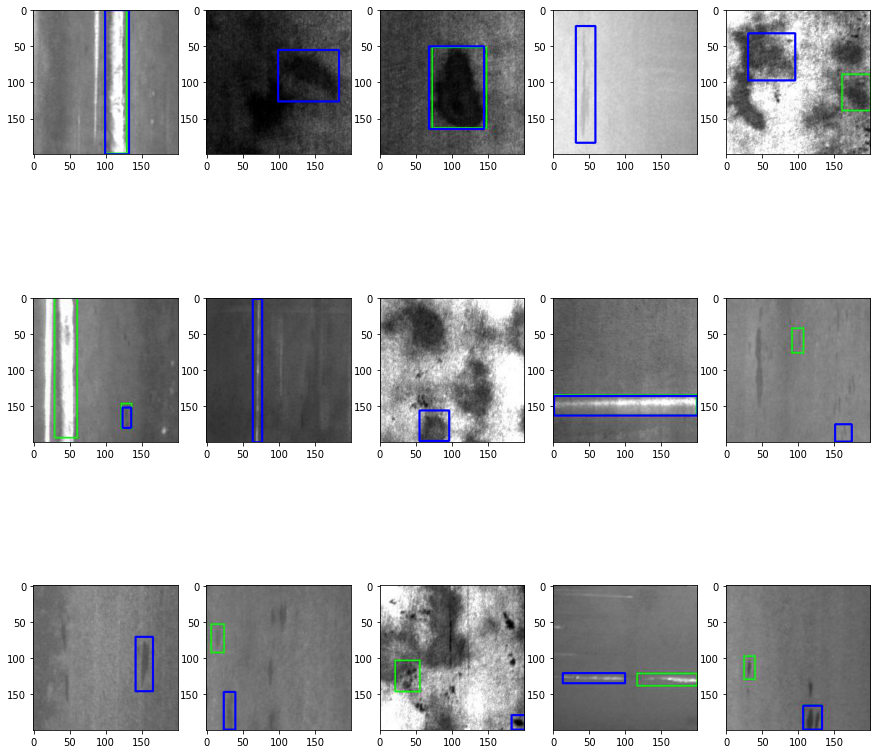

In [34]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

images_list = os.listdir("/workspace/tlt-experiments/detectnet_v2_aug/tlt_infer_testing/images_annotated/")
rows = 3
columns = 5

fig = plt.figure(figsize=(15, 15))

for i in range(len(images_list)):
    image = np.array(Image.open("/workspace/tlt-experiments/detectnet_v2_aug/tlt_infer_testing/images_annotated/"+images_list[i]))
    with open("/workspace/tlt-experiments/data/val/labels/"+images_list[i].replace("jpg", "txt")) as f:
        x = list(map(float, f.read().split(" ")[4:8]))
    
    cv2.rectangle(image,(int(x[0]), int(x[1])),(int(x[2]), int(x[3])), (0,0,255), 2)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
plt.show()

## 9. Deploy! <a class="anchor" id="head-9"></a>

In [21]:
!mkdir -p $USER_EXPERIMENT_DIR/experiment_dir_final
# Removing a pre-existing copy of the etlt if there has been any.
import os
output_file=os.path.join(os.environ['USER_EXPERIMENT_DIR'],
                         "experiment_dir_final/resnet18_detector.etlt")
if os.path.exists(output_file):
    os.system("rm {}".format(output_file))
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_pruned/resnet18_nopool_bn_detectnet_v2_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY

Using TensorFlow backend.
2021-10-22 12:59:32.308813: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:59:35.058430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-22 12:59:35.058628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:59:35.059209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:59:35.059243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:59:35.059301: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic 

2021-10-22 12:59:43.367979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 12:59:43.368598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:1e.0
2021-10-22 12:59:43.368660: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-10-22 12:59:43.368718: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-10-22 12:59:43.368754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-10-22 12:59:43.368775: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.1

In [22]:
print('Exported model:')
print('------------')
!ls -lh $USER_EXPERIMENT_DIR/experiment_dir_final

Exported model:
------------
total 36M
-rw-r--r-- 1 root root 36M Oct 22 12:59 resnet18_detector.etlt


### A. Int8 Optimization <a class="anchor" id="head-9-1"></a>
DetectNet_v2 model supports int8 inference mode in TRT. In order to use int8 mode, we must calibrate the model to run 8-bit inferences. This involves 2 steps

* Generate calibration tensorfile from the training data using tlt-int8-tensorfile
* Use tlt-export to generate int8 calibration table.

*Note: For this example, we generate a calibration tensorfile containing 10 batches of training data.
Ideally, it is best to use atleast 10-20% of the training data to calibrate the model. The more data provided during calibration, the closer int8 inferences are to fp32 inferences.*

*Note: If the model was trained with QAT nodes available, please refrain from using the post training int8 optimization as mentioned below. Please export the model in int8 mode (using the arg `--data_type int8`) with just the path to the calibration cache file (using the argument `--cal_cache_file`)*

In [ ]:
!tlt-int8-tensorfile detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti.txt \
                                  -m 10 \
                                  -o $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor

In [ ]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin
!tlt-export detectnet_v2 \
            -m $USER_EXPERIMENT_DIR/experiment_dir_retrain/weights/resnet18_detector_pruned.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
            -k $KEY  \
            --cal_data_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.tensor \
            --data_type int8 \
            --batches 10 \
            --batch_size 4 \
            --max_batch_size 4\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
            --verbose

### B. Generate TensorRT engine <a class="anchor" id="head-9-2"></a>
Verify engine generation using the `tlt-converter` utility included with the docker.

The `tlt-converter` produces optimized tensorrt engines for the platform that it resides on. Therefore, to get maximum performance, please instantiate this docker and execute the `tlt-converter` command, with the exported `.etlt` file and calibration cache (for int8 mode) on your target device. The converter utility included in this docker only works for x86 devices, with discrete NVIDIA GPU's. 

For the jetson devices, please download the converter for jetson from the dev zone link [here](https://developer.nvidia.com/tlt-converter). 

If you choose to integrate your model into deepstream directly, you may do so by simply copying the exported `.etlt` file along with the calibration cache to the target device and updating the spec file that configures the `gst-nvinfer` element to point to this newly exported model. Usually this file is called `config_infer_primary.txt` for detection models and `config_infer_secondary_*.txt` for classification models.

In [ ]:
!tlt-converter $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.etlt \
               -k $KEY \
               -c $USER_EXPERIMENT_DIR/experiment_dir_final/calibration.bin \
               -o output_cov/Sigmoid,output_bbox/BiasAdd \
               -d 3,384,1248 \
               -i nchw \
               -m 64 \
               -t int8 \
               -e $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector.trt \
               -b 4

## 10. Verify Deployed Model <a class="anchor" id="head-10"></a>
Verify the exported model by visualizing inferences on TensorRT.
In addition to running inference on a `.tlt` model in [step 8](#head-8), the `tlt-infer` tool is also capable of consuming the converted `TensorRT engine` from [step 9.B](#head-9-2).

*If after int-8 calibration the accuracy of the int-8 inferences seem to degrade, it could be because the there wasn't enough data in the calibration tensorfile used to calibrate thee model or, the training data is not entirely representative of your test images, and the calibration maybe incorrect. Therefore, you may either regenerate the calibration tensorfile with more batches of the training data, and recalibrate the model, or calibrate the model on a few images from the test set. This may be done using `--cal_image_dir` flag in the `tlt-export` tool. For more information, please follow the instructions in the USER GUIDE.

### A. Inference using TensorRT engine <a class="anchor" id="head-10-1"></a>

In [ ]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt.txt \
                        -o $USER_EXPERIMENT_DIR/etlt_infer_testing \
                        -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                        -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'etlt_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

## 11. QAT workflow <a class="anchor" id="head-11"></a>
This section delves into the newly enabled Quantization Aware Training feature with DetectNet_v2. The workflow defined below converts a pruned model from section [5](#head-5). 

### A. Convert pruned model to QAT and retrain <a class="anchor" id="head-11-1"></a>
All detectnet models, unpruned and pruned models can be converted to QAT models by setting the `enable_qat` parameter in the `training_config` component of the spec file to `true`.

In [ ]:
# Printing the retrain experiment file. 
# Note: We have updated the experiment file to convert the
# pretrained model to qat mode by setting the enable_qat
# parameter.
!cat $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt

In [ ]:
!tlt-train detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                        -r $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat \
                        -k $KEY \
                        -n resnet18_detector_pruned_qat \
                        --gpus $NUM_GPUS

In [ ]:
!ls -rlt $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights

### B. Evaluate QAT converted model <a class="anchor" id="head-11-2"></a>
This section evaluates a QAT enabled pruned retrained model. The mAP of this model should be comparable to that of the pruned retrained model without QAT. However, due to quantization, it is possible sometimes to see a drop in the mAP value for certain datasets.

In [ ]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
                           -k $KEY \
                           -f tlt

### C. Export QAT trained model to int8 <a class="anchor" id="head-11-3"></a>
Export a QAT trained model to TensorRT parsable model. This command generates an .etlt file from the trained model and the serializes corresponding int8 scales as a TRT readable calibration cache file.

In [ ]:
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt
!rm -rf $USER_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin
!tlt-export detectnet_v2 -m $USER_EXPERIMENT_DIR/experiment_dir_retrain_qat/weights/resnet18_detector_pruned_qat.tlt \
            -o $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.etlt \
            -k $KEY  \
            --data_type int8 \
            --batch_size 64 \
            --max_batch_size 64\
            --engine_file $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
            --cal_cache_file $USER_EXPERIMENT_DIR/experiment_dir_final/calibration_qat.bin \
            --verbose

### D. Evaluate a QAT trained model using the exported TensorRT engine <a class="anchor" id="head-11-4"></a>
This section evaluates a QAT enabled pruned retrained model using the TensorRT int8 engine that was exported in [Section C](#head-11-3). Please note that there maybe a slight difference (~0.1-0.5%) in the mAP from [Section B](#head-11-2), oweing to some differences in the implementation of quantization in TensorRT.

*Note: The TRT evaluator might be slightly slower than the TLT evaluator here, because the evaluation dataloader is pinned to the CPU to avoid any clashes between TRT and TLT instances in the GPU. Please note that this tool was not intended and has not been developed for profiling the model. It is just a means to qualitatively analyse the model.*

*Please use native TensorRT or DeepStream for the most optimized inferences.*

In [ ]:
!tlt-evaluate detectnet_v2 -e $SPECS_DIR/detectnet_v2_retrain_resnet18_kitti_qat.txt \
                           -m $USER_EXPERIMENT_DIR/experiment_dir_final/resnet18_detector_qat.trt.int8 \
                           -f tensorrt

### D. Inference using QAT engine <a class="anchor" id="head-11-5"></a>
Run inference and visualize detections on test images, using the exported TensorRT engine from [Section C](#head-11-3).

In [ ]:
!tlt-infer detectnet_v2 -e $SPECS_DIR/detectnet_v2_inference_kitti_etlt_qat.txt \
                        -o $USER_EXPERIMENT_DIR/tlt_infer_testing_qat \
                        -i $DATA_DOWNLOAD_DIR/testing/image_2 \
                        -k $KEY

In [ ]:
# visualize the first 12 inferenced images.
OUTPUT_PATH = 'tlt_infer_testing_qat/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)